In [105]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose


In [106]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

# Task 1


In [107]:
df = pd.read_csv("palm_oil_data/production_good.csv")
df = df[df.Region=="JH"]
df.head()

,index,Region,Year,Month,Production,Diff_production
0,0,JH,1998,1,118.359,0.000
1,1,JH,1998,2,147.988,0.000
2,2,JH,1998,3,145.514,29.629
3,3,JH,1998,4,154.638,-2.474
4,4,JH,1998,5,155.827,9.124


In [108]:
production = np.array(df.Production)
differences = np.array(df.Diff_production)
time = np.arange(1, production.shape[0] + 1, 1)
time.shape

(237,)

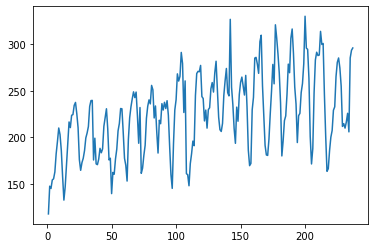

In [109]:
plt.plot(time, production, '-')
plt.show()

### The magnitude of the seasonal and resuduals are independent of trend. Thus, this time series is addidtive.

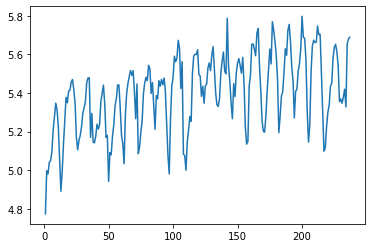

In [110]:
production_mul = np.log(production)
plt.plot(time, production_mul, '-')
plt.show()

# Task 2

In [111]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

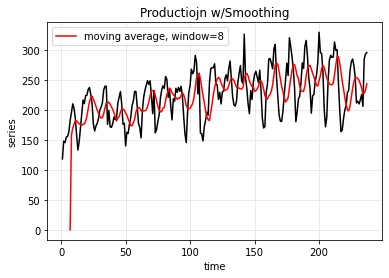

In [112]:
smoothed_production = moving_average(production, window=8, forecast=False)

run_sequence_plot(time, production,
                  title="Productiojn w/Smoothing")
plt.plot(time[6:], np.insert(smoothed_production,0,0), 'r', label="moving average, window=8")
plt.legend();

In [113]:
def ewma(observations, forecast=True):
    '''returns the exponentially weighted smoothed version of an array of observations.'''
    weights = np.array([0.160, 0.294, 0.543])
    output = np.zeros_like(observations, dtype='float')
    for i, _ in enumerate(observations):
        if (i == 0) or (i == 1) or (i == len(observations) - 1):
            pass
        else:
            output[i] = np.dot(observations[i-2:i+1], weights)
    if forecast:
        return np.insert(output, 0, 0)
    else:
        return output

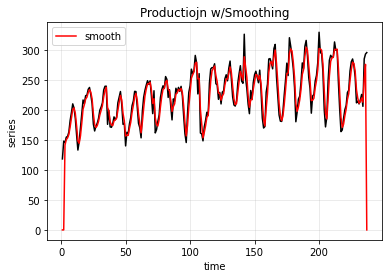

In [114]:
ewma_smoothed_vals = ewma(production, forecast=False)


run_sequence_plot(time, production,
                  title="Productiojn w/Smoothing")
plt.plot(time, ewma_smoothed_vals, 'r', label="smooth")
plt.legend();


Differencing:

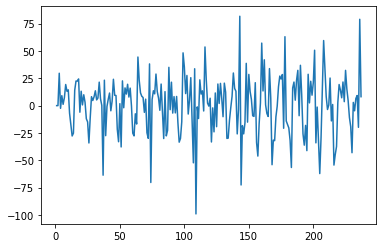

In [115]:
plt.plot(time, differences)

In [116]:
# split data into 10 chunks
chunks = np.split(differences[0:200], indices_or_sections=5)

# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 1.31518 | 337.54
    2 | 1.72975 | 482.483
    3 | 0.919975 | 766.828
    4 | -1.1869 | 776.912
    5 | 1.2332 | 749.218


#### We see that the variance is increasing, thus, it is probably not stationary, although adfuller test says that it's stationary

# Task 3

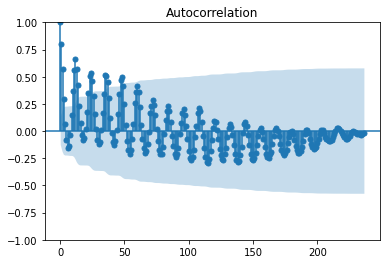

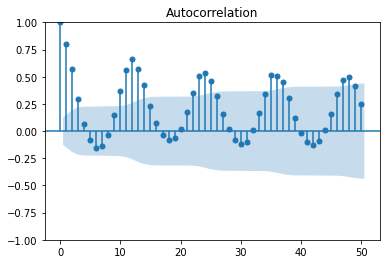

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(x=production, lags=236)
plot_acf(x=production, lags=50)

plt.show()

We can see that the period here is equal to 12 months or 1 year, so let's decompose the series:

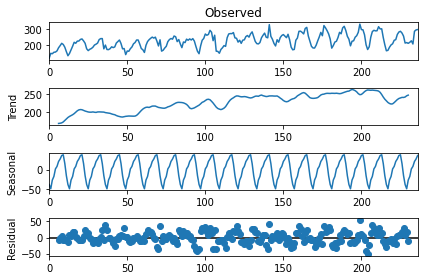

In [15]:
# decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=production, model='additive', period=12)
trend = ss_decomposition.trend
seasonality = ss_decomposition.seasonal
residuals = ss_decomposition.resid
ss_decomposition.plot();


Let's test our residuals for stationarity:

In [27]:
from statsmodels.tsa.stattools import adfuller

adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(residuals[x:-x])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -7.90112919455443
p-value:  4.1823822199069874e-12


Here **pvalue** is very close to zero so we reject the null that this data is nonstationary. The p-value is less that 0.05, so it is stationary!

ADF:  -5.963963483169554
p-value:  2.0081933061024862e-07


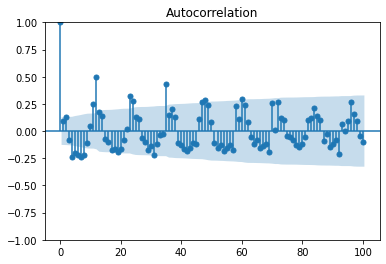

In [55]:
plot_acf(x=differences, lags=100)
from statsmodels.tsa.stattools import adfuller

adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(differences[x:-x])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

In [ ]:
# differencing:

# Task 4

In [18]:
x = 16
train = production[:-x]
test = production[-x:]
time.shape, train.shape, test.shape

((237,), (221,), (16,))

In [19]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

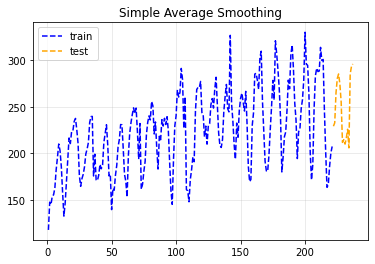

In [20]:
plt.plot(time[:-x], train, 'b--', label="train")
plt.plot(time[-x:], test, color='orange', linestyle="--", label="test")
# plt.plot(time[-12:], simple_avg_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);

In [21]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [207.44881891 207.44881891 207.44881891 207.44881891 207.44881891
 207.44881891 207.44881891 207.44881891 207.44881891 207.44881891
 207.44881891 207.44881891 207.44881891 207.44881891 207.44881891
 207.44881891]
MSE:  44033.21370221608


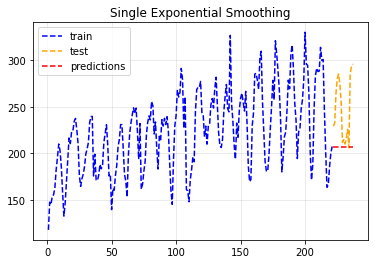

In [22]:
plt.plot(time[:-x], train, 'b--', label="train")
plt.plot(time[-x:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-x:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

### Double exponential

In [23]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [206.67845195 206.16234528 205.64623862 205.13013196 204.6140253
 204.09791864 203.58181198 203.06570532 202.54959866 202.03349199
 201.51738533 201.00127867 200.48517201 199.96906535 199.45295869
 198.93685203]
MSE:  50857.27112460545


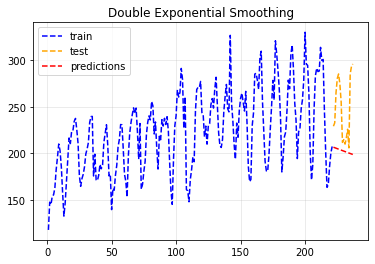

In [24]:
plt.plot(time[:-x], train, 'b--', label="train")
plt.plot(time[-x:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-x:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

### Triple exponential smoothing

In [25]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [208.13053811 211.38304429 217.01548701 220.57914023 221.48442977
 220.66839942 226.06256425 223.35127792 220.00455192 211.38577511
 211.7789961  210.97317091 203.28911323 204.07810385 207.33061004
 212.96305276]
MSE:  35611.75547413097


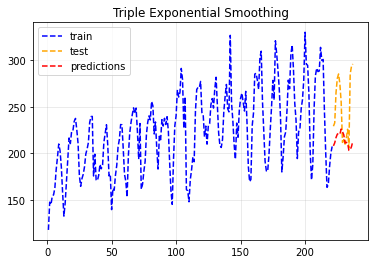

In [26]:
plt.plot(time[:-x], train, 'b--', label="train")
plt.plot(time[-x:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-x:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

# Task 5

In [125]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [142]:
# build and summarize model
model = pf.ARIMA(data=residuals, ar=2, ma=2, integ=0, target='temp')
x = model.fit("MLE")
x.summary()

NameError: name 'pf' is not defined

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  237
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -971.700
Date:                Mon, 18 Oct 2021   AIC                           1955.400
Time:                        23:55:48   BIC                           1976.183
Sample:                             0   HQIC                          1963.778
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3548      0.058     -6.080      0.000      -0.469      -0.240
ar.L2         -0.1109      0.071     -1.570      0.116      -0.249       0.028
ar.L3         -0.0878      0.087     -1.006      0.3

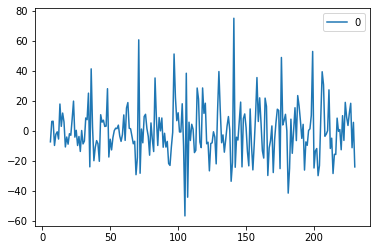

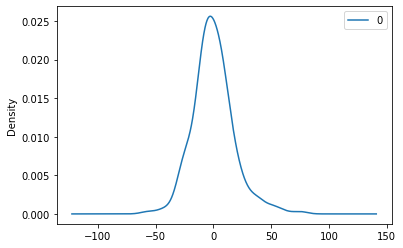

                0
count  225.000000
mean     0.048311
std     17.878794
min    -56.612630
25%     -9.814424
50%     -0.650884
75%      8.660134
max     75.144263


In [144]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from pandas import DataFrame
# load dataset

series = residuals
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())